# Deep Deterministic Policy Gradients (DDPG)
---
In this notebook, we train DDPG with OpenAI Gym's Pendulum-v0 environment.

### 1. Import the Necessary Packages

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import gym
import random
import torch
import numpy as np
import pandas as pd
from collections import deque
import matplotlib.pyplot as plt
import datetime as dt

%matplotlib inline

from ddpg_agent import Agent

In [3]:
import os
import sys

repo_path = os.path.dirname(os.path.dirname(os.path.abspath("__file__")))
repo_path
sys.path.append(repo_path)

### 2. Instantiate the Environment and Agent

In [4]:
env = gym.make('Pendulum-v0')
env.seed(2)
agent = Agent(state_size=3, action_size=1, random_seed=2)

In [5]:
state_size = env.observation_space.shape[0]
action_size = env.action_space.shape[0]
print('State shape: ', state_size)
print('Number of actions: ', state_size)

State shape:  3
Number of actions:  3


In [6]:
env.action_space.low, env.action_space.high

(array([-2.], dtype=float32), array([2.], dtype=float32))

In [7]:
num_agents = 1
experiences = []
t_step = 0
scores = np.zeros(num_agents)  
scores_hist = np.zeros((0, num_agents))
scores_window = deque(maxlen=100)
    
# watch an untrained agent
states = env.reset()
while True:
    actions = agent.act(states)
    states, rewards, dones, _ = env.step(actions)
    experiences.append((states, actions, rewards))
    scores += rewards
    t_step += 1
    if np.any(dones):
        scores_hist = np.vstack([scores_hist, scores])
        scores_window.append(scores)
        break 
        

In [8]:
t_step, scores, np.mean(scores_hist), np.mean(scores_window)

(200, array([-1341.86284827]), -1341.8628482684444, -1341.8628482684444)

In [9]:
states = env.reset()
t_step = 0
scores = np.zeros(num_agents)  

while True:
    actions = agent.act(states)
    states, rewards, dones, _ = env.step(actions)
    experiences.append((states, actions, rewards))
    scores += rewards
    t_step += 1
    if np.any(dones):
        scores_hist = np.vstack([scores_hist, scores])
        scores_window.append(scores)
        break 
        

In [10]:
t_step, scores, np.mean(scores_hist), np.mean(scores_window)

(200, array([-1260.34965547]), -1301.1062518709334, -1301.1062518709334)

### 3. Train the Agent with DDPG

In [11]:
from src.ac_agent import AgentDDPG, GaussianProcess, OUNoise
from ddpg_train import train

In [12]:
def action_scaler(actions):
    """Clips action values between -2 and 2"""
    
    return np.clip(actions, -2, 2)

In [13]:
RND_SEED = 123
num_agents = 1
EXP_NAME = "ddpg:v03"
EXP_FOLDER = "ddpg3"

In [15]:
g_noise = GaussianProcess(num_agents, RND_SEED)

In [16]:
ddpg_agent = AgentDDPG(
    state_size=state_size, action_size=action_size, gamma=0.99,
    actor_hidden_layers=(256, 128), critic_hidden_layers=(256, 128),
    batch_size=128, learning_rates=(1e-4, 1e-3), grad_clipping=(False, False), weight_decay=(0, 1e-2),
    soft_upd_param=1e-3, update_every=1, buffer_size=int(1e5),
    noise=g_noise, learn_every=1, learn_num=1,
    seed=RND_SEED, action_dtype='float')

In [17]:
path_ddpg_agent = os.path.join('models', EXP_FOLDER)

scores_ddpg = train(
    env, ddpg_agent, n_episodes=500, max_t=200, solved=-50, action_scaler_fn=action_scaler,
    add_noise=True, noise_decay=1., min_noise_weight=1.,
    model_save_path=path_ddpg_agent)

Episode [100/500]	Average score: -1,147.12
Episode [200/500]	Average score: -464.30
Episode [300/500]	Average score: -285.70
Episode [400/500]	Average score: -298.18
Episode [500/500]	Average score: -273.38


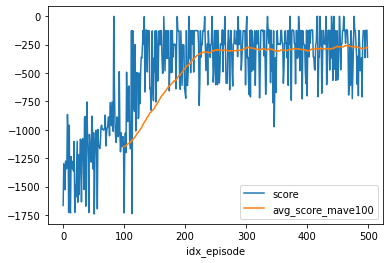

In [18]:
scores_ddpg.plot(y=['score', 'avg_score_mave100'])
plt.show()

In [19]:
scores_ddpg['experiment'] = EXP_NAME


In [20]:
checkpoint_metadata = pd.Series(index=['N_episodes', 'gamma', 'actor_hidden_layers', 'critic_hidden_layers',
                'grad_clipping', 'batch_size', 'learning_rates',
                'soft_upd_param', 'update_every', 'buffer_size', 'noise', 'solved',
                'checkpoint_folder'],
         data = [len(scores_ddpg), 0.99, [256, 128], [256, 128], 
                 (0, 1.), 128, (1e-3, 1e-3), 1e-3, 4, int(1e5), 'g-noise', True, EXP_FOLDER], name=f'experiment:{EXP_NAME}')
checkpoint_metadata

N_episodes                         500
gamma                             0.99
actor_hidden_layers         [256, 128]
critic_hidden_layers        [256, 128]
grad_clipping                 (0, 1.0)
batch_size                         128
learning_rates          (0.001, 0.001)
soft_upd_param                   0.001
update_every                         4
buffer_size                     100000
noise                          g-noise
solved                            True
checkpoint_folder                ddpg3
Name: experiment:ddpg:v03, dtype: object

In [21]:
experiment_dt = dt.datetime.strftime(dt.datetime.now(), "%Y%m%d%H%M%S")

In [22]:
checkpoint_metadata.to_json(f'models/experiments/hparams_{experiment_dt}.json')
scores_ddpg.to_csv(f'models/experiments/scores_{experiment_dt}.csv')